The estimated value of beta for the original data is: [ 0.71103804 -0.22195264]
Mean of bootstrap estimates: [ 0.70956456 -0.22258802]
Standard deviation of bootstrap estimates: [0.13857936 0.14368107]
Mean of moving blocks bootstrap estimates: [ 0.42448174 -0.12325029]
Standard deviation of moving blocks bootstrap estimates: [0.14746997 0.12725042]


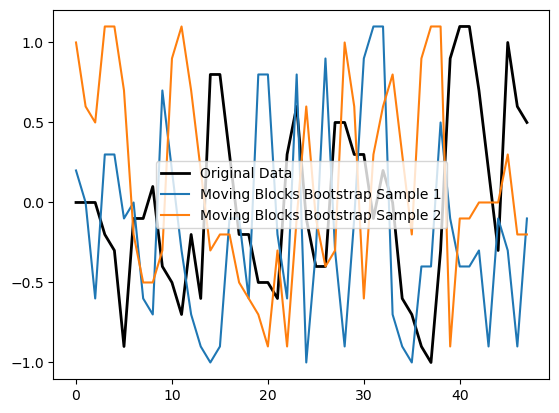

In [3]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# Provided Y data
Y = np.array([2.4, 2.4, 2.4, 2.2, 2.1, 1.5, 2.3, 2.3, 2.5, 2.0, 1.9, 1.7, 2.2, 1.8, 3.2, 3.2, 2.7, 2.2, 2.2, 1.9, 1.9, 1.8, 2.7, 3.0, 2.3, 2.0, 2.0, 2.9, 2.9, 2.7, 2.7, 2.3, 2.6, 2.4, 1.8, 1.7, 1.5, 1.4, 2.1, 3.3, 3.5, 3.5, 3.1, 2.6, 2.1, 3.4, 3.0, 2.9])
T = len(Y)

# Calculate Z = Y - (1/T)*Sum(Y)
mean_Y = np.mean(Y)
Z = Y - mean_Y

# Function to minimize
def func_to_minimize(beta, Z):
    T = len(Z)
    return sum((Z[t] - beta[0]*Z[t-1] - beta[1]*Z[t-2])**2 for t in range(2, T))

# Use scipy's optimize function to perform the minimization
result = scipy.optimize.minimize(func_to_minimize, [0.5, 0.5], args=(Z,))

# The optimal beta is
beta_est = result.x

# Compute residuals
eps_est = Z[2:] - beta_est[0] * Z[1:-1] - beta_est[1] * Z[:-2]

# Number of bootstrap samples
num_bootstrap_samples = 200

# Array to store bootstrap estimates
bootstrap_estimates = np.zeros((num_bootstrap_samples, 2))

# Bootstrapping
for i in range(num_bootstrap_samples):
    # Generate bootstrap sample of residuals
    boot_eps = np.random.choice(eps_est, size=T-2, replace=True)

    # Generate bootstrap sample from the model
    bootstrap_sample = np.zeros(T)
    bootstrap_sample[0:2] = Z[0:2]
    for t in range(2, T):
        bootstrap_sample[t] = beta_est[0] * bootstrap_sample[t-1] + beta_est[1] * bootstrap_sample[t-2] + boot_eps[t-2]

    # Estimate beta for the bootstrap sample
    result = scipy.optimize.minimize(func_to_minimize, [0.5, 0.5], args=(bootstrap_sample,))

    # Store the bootstrap estimate
    bootstrap_estimates[i] = result.x

# Compute the mean and standard deviation of the bootstrap estimates
bootstrap_mean = np.mean(bootstrap_estimates, axis=0)
bootstrap_std = np.std(bootstrap_estimates, axis=0)

print(f'The estimated value of beta for the original data is: {beta_est}')
print(f'Mean of bootstrap estimates: {bootstrap_mean}')
print(f'Standard deviation of bootstrap estimates: {bootstrap_std}')

# Moving Blocks Bootstrap
def moving_blocks_bootstrap(data, block_size, num_bootstrap_samples):
    # Generate bootstrap samples
    bootstrap_samples = []
    for _ in range(num_bootstrap_samples):
        # Generate starting indices for blocks
        start_indices = np.random.choice(range(len(data) - block_size + 1), size=(len(data) // block_size), replace=True)
        # Generate blocks and concatenate
        blocks = [data[i:i+block_size] for i in start_indices]
        bootstrap_sample = np.concatenate(blocks)
        # If bootstrap sample is shorter than original data (due to floor division), add some more values
        if len(bootstrap_sample) < len(data):
            bootstrap_sample = np.concatenate((bootstrap_sample, data[:len(data)-len(bootstrap_sample)]))
        bootstrap_samples.append(bootstrap_sample)
    return bootstrap_samples

# Choose block size
block_size = 3

# Generate moving blocks bootstrap samples
bootstrap_samples_moving_blocks = moving_blocks_bootstrap(Z, block_size, num_bootstrap_samples)

# For each bootstrap sample, estimate beta
bootstrap_estimates_moving_blocks = np.zeros((num_bootstrap_samples, 2))
for i, bootstrap_sample in enumerate(bootstrap_samples_moving_blocks):
    # Estimate beta for the bootstrap sample
    result = scipy.optimize.minimize(func_to_minimize, [0.5, 0.5], args=(bootstrap_sample,))
    bootstrap_estimates_moving_blocks[i] = result.x

# Compute the mean and standard deviation of the bootstrap estimates
bootstrap_mean_moving_blocks = np.mean(bootstrap_estimates_moving_blocks, axis=0)
bootstrap_std_moving_blocks = np.std(bootstrap_estimates_moving_blocks, axis=0)

print(f'Mean of moving blocks bootstrap estimates: {bootstrap_mean_moving_blocks}')
print(f'Standard deviation of moving blocks bootstrap estimates: {bootstrap_std_moving_blocks}')

# Plot original data and a few bootstrap samples for illustration
plt.plot(Z, label='Original Data', linewidth=2, color='black')
for i, bootstrap_sample in enumerate(bootstrap_samples_moving_blocks[:2]):
    plt.plot(bootstrap_sample, label=f'Moving Blocks Bootstrap Sample {i+1}')
plt.legend()
plt.show()
